In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torchvision.models as models

import time
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
import numpy as np

data = Path("data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Style transfer

Components of neural style transfer : 
- Pretrained object detection network to create feature maps
- Definition of content loss and style loss

Feature responses in higher levels of the network = content representation.

Correlation between different filter responses = style representation.

In [108]:
# Pretrained network (add normalization layer and rename layers)
cnn_loaded = models.vgg19(pretrained=True).features.to(device).eval()

CNN_NORM_MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
CNN_NORM_STD = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, input_tensor):
        normalized_tensor = (input_tensor - self.mean) / self.std
        return normalized_tensor
    
cnn = nn.Sequential()
cnn.add_module("normalization", Normalization(CNN_NORM_MEAN, CNN_NORM_STD))
i = 0
for child in cnn_loaded.children():
    if isinstance(child, nn.Conv2d):
        i += 1
        name = f'conv{i}_1'
    elif isinstance(child, nn.ReLU):
        name = f'relu{i}_1'
        child = nn.ReLU(inplace=False)
    elif isinstance(child, nn.MaxPool2d):
        name = f'pool{i}_1'
    for param in child.parameters():
        param.requires_grad = False
    cnn.add_module(name, child)

We will also need to normalize/unnormalize tensors as the inputs of VGG, as well as go back and forth between the tensor and PIL image format.

In [37]:
def tensor_to_image(tensor):
    return transforms.ToPILImage()(tensor.squeeze(0))

def image_to_tensor(image):
    return transforms.ToTensor()(image).unsqueeze(0).to(device, torch.float)

def get_noise_tensor(ref_image):
    noise_tensor = torch.randn(transforms.ToTensor()(ref_image).data.size(), device=device)
    return noise_tensor.unsqueeze(0)

Finally we will need to load an example content image and an example style image.

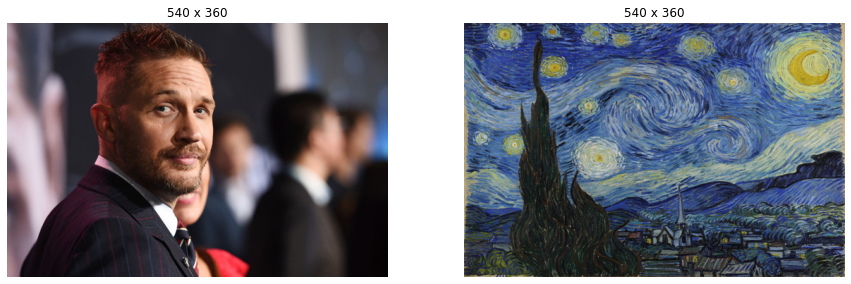

In [38]:
# Get content image and downsize it
content_image = Image.open(Path(data, "content.jpg")).convert('RGB')
content_image = content_image.resize((int(content_image.size[0]/3), int(content_image.size[1]/3)))
w_content, h_content = content_image.size

# Get content image and downsize it
style_image = Image.open(Path(data, "style.jpg")).convert('RGB')
style_image = style_image.resize(content_image.size)
w_style, h_style = style_image.size

# Visualize
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(f"{w_content} x {h_content}")
plt.imshow(content_image)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f"{w_style} x {h_style}")
plt.imshow(style_image)
plt.show()

# Content loss and Style loss

Given a **content image $p$** and a generated **white noise image $x$**, we examine the feature maps generated by the different convolutional layers of the pre-trained network VGG19. For the layer $l$, we denote $N_l$ the number of feature maps and $M_l$ their size (height $*$ weigth of the feature map). Thus, the responses of the layer $l$ for the image $P$ can be stored in a $N_l * M_l$ matrix $P^l$ where $P^l_{ij}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. This matrix is referred to as the feature representation of the input image at layer $l$.

Given $P^l$ and $F^l$, the feature representations of respectively $p$ and $x$, the content loss is defined as $\frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$.

The factor wl was always equal to one divided by the number of active layers
with a non-zero loss-weight wl

In [121]:
# Constructing a new model by inserting intermediary layers seems optimal and more clear
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = torch.nn.MSELoss(reduction='sum')(input, self.target)
        return input
    
def gram_matrix(feature_maps):
    batch_size, n_feature_maps, h, w = feature_maps.size()

    # This transformation allows a direct inner prod without looping over feature maps
    features = feature_maps.view(batch_size * n_feature_maps, h * w)

    gram_matrix = torch.mm(features, features.t())  # compute the gram product
    #gram_matrix = gram_matrix.div(batch_size * n_feature_maps * h * w)
    return gram_matrix

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = torch.nn.MSELoss(reduction='sum')(G, self.target)
        return input

In [125]:
class NeuralStyleTransfer:
    
    def __init__(self, content_tensor, pretrained_network):
        self.content_tensor = content_tensor
        self.pretrained_network = pretrained_network
        self.pretrained_network.requires_grad_(False)
        
    def construct_model(self, style_tensor, content_layer, style_layers):
        
        # Construct new model by inserting custom content/style loss modules
        model = nn.Sequential()
        for name, module in list(self.pretrained_network.named_modules())[1:]:
            model.add_module(name, module)
            if name in style_layers:
                output = model(style_tensor).detach()
                style_loss_module = StyleLoss(output)
                model.add_module(f'{name}_style_loss', style_loss_module)
            if name == content_layer:
                output = model(self.content_tensor).detach()
                content_loss_module = ContentLoss(output)
                model.add_module(f'{name}_content_loss', content_loss_module)
              
        # Trim to remove remaining layers that are not used
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break
        model = model[:(i + 1)]
        return model
            
    def transform(self, 
                  style_tensor, 
                  content_layer = 'conv4_1', 
                  style_layers = [f'conv{i}_1' for i in range(1, 5 + 1)],
                  content_weight = 0.01, 
                  style_weight = 100):
        
        model = self.construct_model(style_tensor, content_layer, style_layers)
        
        # White noise image that we will transform
        noise_tensor = torch.randn(self.content_tensor.data.size(), device=device)
        noise_tensor.requires_grad_(True)

        optimizer = optim.LBFGS([noise_tensor])
        n_iter = 500
        iterations = [0]
        print_freq = 50

        start = time.time()
        while iterations[0] <= n_iter:
            
            def closure():
                
                with torch.no_grad():
                    noise_tensor.clamp_(0, 1)
                    
                optimizer.zero_grad()

                _  = model(noise_tensor)
                
                content_loss = 0
                style_loss = 0
                for name, module in list(model.named_modules())[1:]:
                    if '_content_loss' in name:
                        content_loss += module.loss
                    elif '_style_loss' in name:
                        style_loss += module.loss / len(style_layers)
                    
                final_loss = content_weight * content_loss + style_weight * style_loss
                
                final_loss.backward()

                iterations[0] += 1
                if iterations[0] % print_freq == 0:
                    print(f"Iteration {iterations[0]}: loss = {final_loss.item()}")
                
                return final_loss
                      
            optimizer.step(closure)
                      
        with torch.no_grad():
            noise_tensor.clamp_(0, 1)

        end = time.time()
        print(f"Done in {iterations[0]} passes, elapsed time = {(end - start)/60.:.3f} min")
        return noise_tensor

Iteration 50: loss = 941667888660480.0
Iteration 100: loss = 222104670699520.0
Iteration 150: loss = 116524736053248.0
Iteration 200: loss = 79463748468736.0
Iteration 250: loss = 58624739115008.0
Iteration 300: loss = 46876011266048.0
Iteration 350: loss = 38867407208448.0
Iteration 400: loss = 33017812746240.0
Iteration 450: loss = 28319548440576.0
Iteration 500: loss = 24074394796032.0
Done in 520 passes, elapsed time = 14.889 min


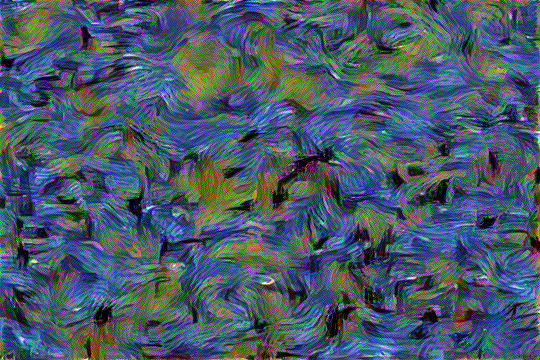

In [126]:
ci = image_to_tensor(content_image)
si = image_to_tensor(style_image.resize(content_image.size))

nst = NeuralStyleTransfer(ci, cnn)
res = nst.transform(si)
tensor_to_image(res)

# Reconstructions

Reconstruct images that match a given subnetworks output.

In [27]:
# Example with first conv 
content_model = conv2_1
content_loss = get_content_loss(content_model, content_image)

input_tensor = get_noise_tensor(content_image)
input_tensor.requires_grad_(True)

optimizer = optim.LBFGS([input_tensor])

n_iter = 500
iterations = [0]
print_freq = 50

start = time.time()
while iterations[0] <= n_iter:
    
    def closure():
        with torch.no_grad():
            input_tensor.clamp_(0, 1)
        optimizer.zero_grad()
        
        input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
        input_output = content_model(input_norm)
        
        loss = content_loss(input_output)
        loss.backward()
                
        iterations[0] += 1
        if iterations[0] % print_freq == 0:
            print(f"Iteration {iterations[0]}: content loss = {loss.item()}")
        
        return loss
            
    optimizer.step(closure)
    
    with torch.no_grad():
        input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
        input_output = content_model(input_norm)
        actual_loss = content_loss(input_output).item()
    
with torch.no_grad():
    input_tensor.clamp_(0, 1)
    
end = time.time()
print(f"Done in {iterations[0]} passes, loss = {actual_loss}, elapsed time = {(end - start)/60.:.3f} min")

Iteration 50: content loss = 351345.625
Iteration 100: content loss = 28252.140625
Iteration 150: content loss = 6096.4384765625
Iteration 200: content loss = 2035.268310546875
Iteration 250: content loss = 1063.144775390625
Iteration 300: content loss = 356.1131591796875
Iteration 350: content loss = 207.07386779785156
Iteration 400: content loss = 827.5223388671875
Iteration 450: content loss = 85.87777709960938
Iteration 500: content loss = 22.129451751708984
Done in 520 passes, loss = 63.88397979736328, elapsed time = 5.888 min


* Conv1_1 : n_passes = 513, final loss = 7.05e-07, elasped time = 1.66min
* Conv2_1 : n_passes = 520, final loss = 63.88, elasped time = 5.8min
* Conv3_1 : n_passes = , final loss = , elasped time = 
* Conv4_1 : n_passes = , final loss = , elasped time = 
* Conv5_1 : n_passes = , final loss = , elasped time =  

In [25]:
# tensor_to_image(input_tensor).save("data/conv1_content_reconstruction.png") # 0.75 min to go under 10e-3 loss
# tensor_to_image(input_tensor).save("data/conv2_content_reconstruction.png") # 2.89 min to go under 500 loss
# tensor_to_image(input_tensor)

In [12]:
# Example with first conv 
conv_models = [conv1_1, conv2_1]
weight = 1 / len(conv_models)

style_losses = []
for model in conv_models:
    
    style_tensor = image_to_tensor(style_image)
    style_input = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(style_tensor)
    
    style_output = model(style_input)
    style_loss = StyleLoss(style_output)
    style_losses.append(style_loss)

input_tensor = get_noise_tensor(style_image)
input_tensor.requires_grad_(True)

optimizer = optim.LBFGS([input_tensor])
n_iterations = 30
print_freq = 5

iterations = [0]
start = time.time()
while iterations[0] <= (n_iterations):
            
    def closure():
                
        # correct the values of updated input image
        with torch.no_grad():
            input_tensor.clamp_(0, 1)
                    
        optimizer.zero_grad()
        loss = 0
        for model, sloss in zip(conv_models, style_losses):
            input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
            input_output = model(input_norm)
            loss += weight * sloss(input_output)
        loss.backward()
                
        iterations[0] += 1
        if iterations[0] % print_freq == 0:
            print(f"Iteration {iterations[0]}: style loss = {loss.item()}")
        
        return loss
            
    optimizer.step(closure)
    
with torch.no_grad():
    input_tensor.clamp_(0, 1)
    
end = time.time()
print(f"Done in {iterations[0]} passes, elapsed time = {(end - start)/60.:.3f} min")

Iteration 5: style loss = 1.8107984066009521
Iteration 10: style loss = 0.10988658666610718
Iteration 15: style loss = 0.0328841358423233
Iteration 20: style loss = 0.01769372820854187
Iteration 25: style loss = 0.011603090912103653
Iteration 30: style loss = 0.008797628805041313
Iteration 35: style loss = 0.0073266285471618176
Iteration 40: style loss = 0.006242093630135059
Done in 40 passes, elapsed time = 2.250 min


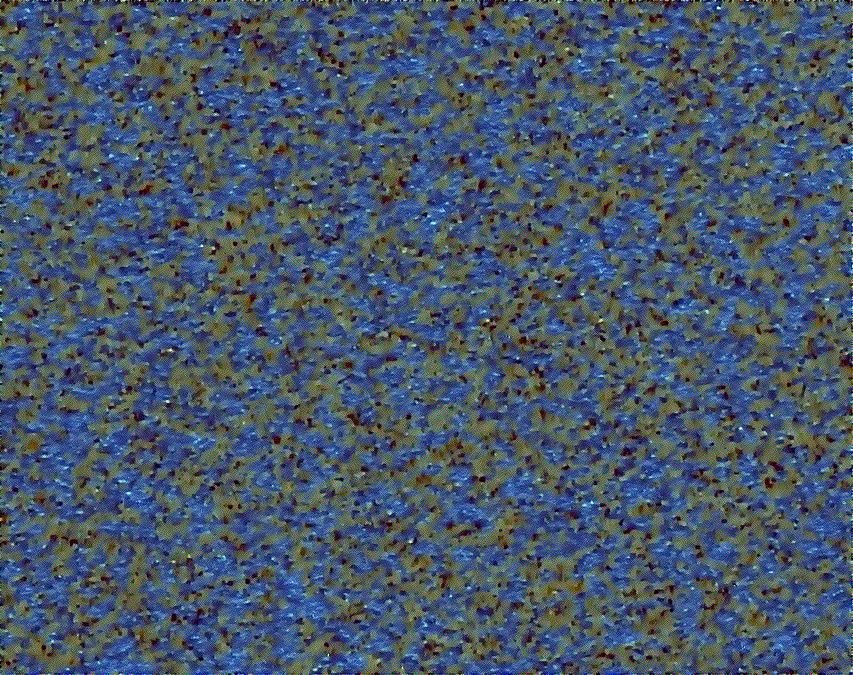

In [13]:
tensor_to_image(input_tensor)

# Combining both losses

In [44]:
# Content model and content loss
content_model = conv4_1
content_loss = get_content_loss(content_model, content_image)

# Style model and styles losses Resize style image to content image size
conv_models = [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]
weight = 1 / len(conv_models)

style_image_cp = style_image.resize(content_image.size)
style_losses = []
for model in conv_models:
    
    style_tensor = image_to_tensor(style_image_cp)
    style_input = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(style_tensor)
    
    style_output = model(style_input)
    style_loss = StyleLoss(style_output)
    style_losses.append(style_loss)
    
# Input image
input_tensor = get_noise_tensor(content_image)
input_tensor.requires_grad_(True)

# Optimizer
optimizer = optim.LBFGS([input_tensor])

# Config
n_iterations = 300
print_freq = 50
iterations = [0]
start = time.time()

content_weight = 0.01
style_weight = 100000

while iterations[0] <= (n_iterations):
            
    def closure():
        
        with torch.no_grad():
            input_tensor.clamp_(0, 1)            
        optimizer.zero_grad()
        
        # Content component
        input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
        input_output = content_model(input_norm)
        loss1 = content_loss(input_output)
        
        # Style component
        loss2 = 0
        for model, sloss in zip(conv_models, style_losses):
            input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
            input_output = model(input_norm)
            loss2 += weight * sloss(input_output)
        
        loss = content_weight*loss1 + style_weight*loss2  
        loss.backward()
                
        iterations[0] += 1
        if iterations[0] % print_freq == 0:
            print(f"Iteration {iterations[0]}: loss = {loss.item()}")
        
        return loss
            
    optimizer.step(closure)
    
with torch.no_grad():
    input_tensor.clamp_(0, 1)
    
end = time.time()
print(f"Done in {iterations[0]} passes, elapsed time = {(end - start)/60.:.3f} min")

Iteration 50: loss = 1184819.25


KeyboardInterrupt: 

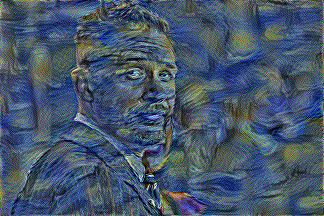

In [42]:
tensor_to_image(input_tensor)

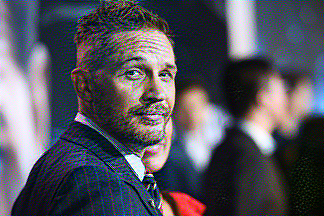

In [35]:
tensor_to_image(input_tensor)